# Replicating plots in the mianserin worm paper

Tong Shu Li

Creating functions allowing plotting of transcriptional drift.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import sys

from itertools import combinations
from scipy.stats import levene

In [2]:
sys.path.append("..")

In [3]:
from src.drift_plots import plot_drift_raw
from src.drift_plots import plot_drift_box

In [4]:
%matplotlib inline

---

## Read the averaged drift data

In [5]:
data = pd.read_csv("../data/worms_mianserin/avg_annotated_cpm_values.tsv", sep = '\t')

In [6]:
data.shape

(130548, 11)

In [7]:
data.head()

,seqname,sample,value,day_harvested,drug_conc_uM,day_drug_added,youngref,trans_drift,drug,wormbaseid,gene_symbol
0,2RSSE.1,1,4.105727,1,0,1,4.105726,-0.012915,water,WBGene00007064,2RSSE.1
1,2RSSE.1,2,7.687213,3,0,1,4.105726,0.562429,water,WBGene00007064,2RSSE.1
2,2RSSE.1,3,7.220500,5,0,1,4.105726,0.562490,water,WBGene00007064,2RSSE.1
3,2RSSE.1,4,3.923197,10,0,1,4.105726,-0.049039,water,WBGene00007064,2RSSE.1
4,2RSSE.1,5,4.042023,3,50,1,4.105726,-0.030335,mianserin,WBGene00007064,2RSSE.1


---

## Levene's test

In [8]:
def stars(p):
   if p < 0.0001:
       return "****"
   elif (p < 0.001):
       return "***"
   elif (p < 0.01):
       return "**"
   elif (p < 0.05):
       return "*"
   else:
       return "n.s."

In [9]:
def get_groups(data, category_col, value_col):
    # group by category column, and return a list of lists
    # containing the values

    return [
        group[value_col]
        for category, group in data.groupby(category_col)
    ]

In [10]:
def levene_test(dataframe, group_cols, value_col):
    # return just the p-value
    return levene(*get_groups(dataframe, group_cols, value_col), center = "median")[1]

In [11]:
def p_val_matrix(data, group_cols, drift_col):
    """Calculate the Levene's test p-value for each unique pair of groups.
    
    Only calculates the lower left triangle.
    """
    drift = {
        key: df[drift_col]
        for key, df in data.groupby(group_cols)
    }
 
    groups = sorted(list(drift.keys()))
    temp = pd.DataFrame(index = groups, columns = groups, dtype = np.float)

    for i, j in combinations(groups, 2):
        temp.loc[i, j] = levene(drift[i], drift[j], center = "median")[1]

    return temp.T

def plot_p_val_heatmap(data, group_cols, drift_col, figsize = (5, 5)):
    p_vals = p_val_matrix(data, group_cols, drift_col)
    
    fig = sns.heatmap(p_vals, annot = True, square = True, linewidths = 0.5)
    fig.set_title("Levene's p-value for every pairwise group")
    return fig

---

## Subsetting functions

In [12]:
def subset(conditions, data):
    assert isinstance(conditions, dict)
    
    temp = pd.DataFrame(conditions, columns = list(conditions.keys()))
    return pd.merge(temp, data, how = "left", on = list(conditions.keys()))

In [13]:
def sample_genes(data, num_genes, gene_col):
    genes = random.sample(set(data[gene_col]), num_genes)
    return subset({gene_col: genes}, data)

## Plot raw drift for a group of genes

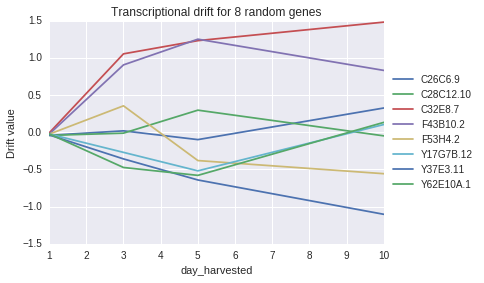

In [14]:
temp = subset(
    {"drug": ["water"]},
    sample_genes(data, 8, "seqname")
)

plot_drift_raw(
    temp, "day_harvested", "seqname", "trans_drift",
    title = "Transcriptional drift for 8 random genes"
)

---

## Boxplot for a random subset of genes

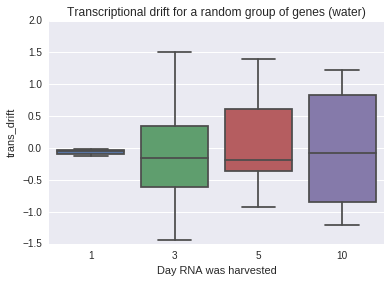

In [15]:
temp = subset(
    {"drug": ["water"]},
    sample_genes(data, 10, "seqname")
)

res = plot_drift_box(
    temp, "day_harvested", "trans_drift", "seqname"
)

res.set_title("Transcriptional drift for a random group of genes (water)")
res.set_xlabel("Day RNA was harvested")

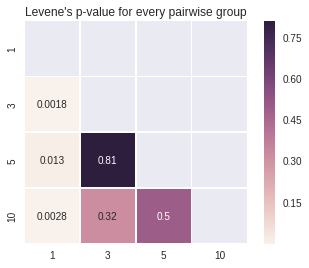

In [16]:
plot_p_val_heatmap(temp, "day_harvested", "trans_drift")

## Plot drift for water treated worms at different days of age

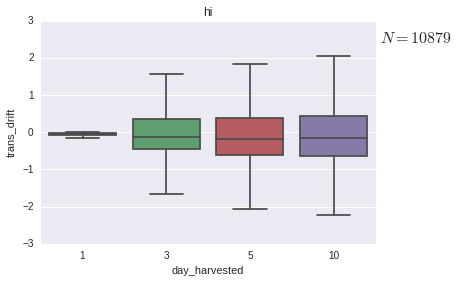

In [17]:
temp = subset(
    {"drug": ["water"]},
    data
)

res = plot_drift_box(
    temp, "day_harvested", "trans_drift", "seqname"
)

res.set_title("hi")
res.annotate(
    r'$N = {}$'.format(len(set(temp["seqname"]))),
    xy = (1, 1), xycoords = "axes fraction",
    fontsize = 16, xytext = (5, -10), textcoords = "offset points",
    ha = "left", va = "top"
)

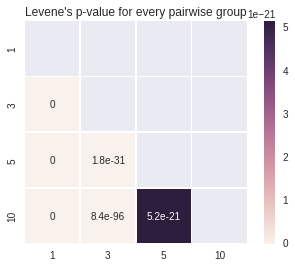

In [18]:
plot_p_val_heatmap(temp, "day_harvested", "trans_drift")

## Plot drift for water and drug worms treated at day 1

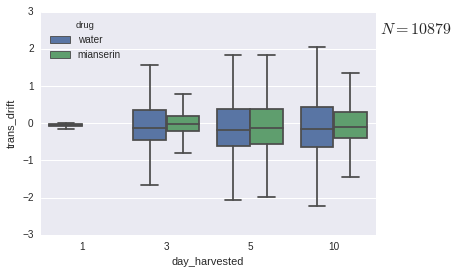

In [19]:
temp = subset(
    {"day_drug_added": [1]},
    data
)

ax = plot_drift_box(
    temp, "day_harvested", "trans_drift", "seqname",
    groupby = "drug"
)

ax.annotate(
    r'$N = {}$'.format(len(set(temp["seqname"]))),
    xy = (1, 1), xycoords = "axes fraction",
    fontsize = 16, xytext = (5, -10), textcoords = "offset points",
    ha = "left", va = "top"
)

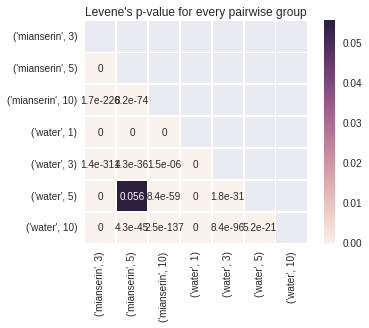

In [20]:
plot_p_val_heatmap(temp, ["drug", "day_harvested"], "trans_drift")

### Same plot, but grouped into subplots instead

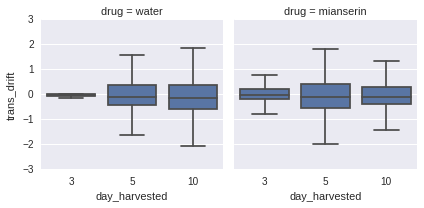

In [21]:
temp = subset(
    {"day_drug_added": [1]},
    data
)

ax = plot_drift_box(
    temp, "day_harvested", "trans_drift", "seqname",
    groupby = "drug", split = True
)

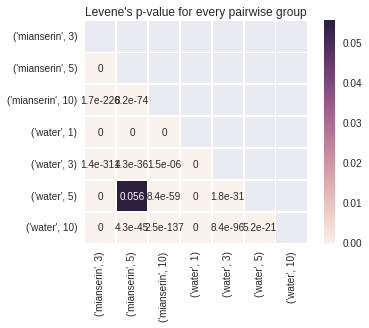

In [22]:
plot_p_val_heatmap(temp, ["drug", "day_harvested"], "trans_drift")

## Drift for mianserin added on different days

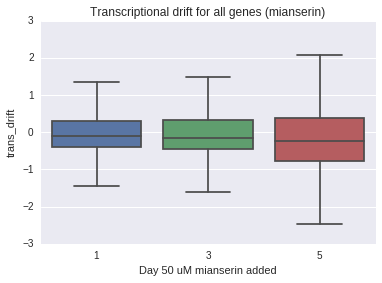

In [23]:
temp = subset(
    {
        "drug": ["mianserin"],
        "drug_conc_uM": 50,
        "day_harvested": 10
    },
    data
)

res = plot_drift_box(
    temp, "day_drug_added", "trans_drift", "seqname"
)

res.set_title("Transcriptional drift for all genes (mianserin)")
res.set_xlabel("Day 50 uM mianserin added")

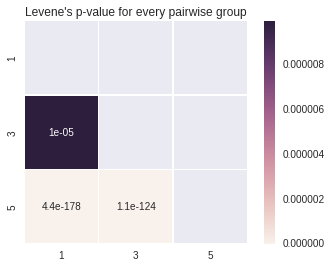

In [24]:
plot_p_val_heatmap(temp, ["day_drug_added"], "trans_drift")